# IMPORTAÇÃO DAS BIBLIOTECAS

In [16]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
import datetime
from scipy import stats
import seaborn as sns
from viz_utils import *
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# IMPORTAÇÃO DOS DATASETS

In [23]:
orders_df=pd.read_csv('dataset/olist_orders_dataset.csv')
customers_df=pd.read_csv('dataset/olist_customers_dataset.csv')
seller_df=pd.read_csv('dataset/olist_sellers_dataset.csv')
items_df=pd.read_csv('dataset/olist_order_items_dataset.csv')
products_df=pd.read_csv('dataset/olist_products_dataset.csv')
product_tr=pd.read_csv('dataset/product_category_name_translation.csv')
order_pay = pd.read_csv("dataset/olist_order_payments_dataset.csv")

# TRADUÇÃO DOS NOMES DOS PRODUTOS PARA O INGLES

In [24]:
category_translations = dict(zip(product_tr['product_category_name'],product_tr['product_category_name_english']))
products_df = products_df.replace({'product_category_name':category_translations})

# MESCLAR TODOS OS DATASETS EM APENAS 1

In [25]:
merge_df=pd.merge(customers_df.drop(['customer_zip_code_prefix'], axis=1), 
                              orders_df.drop(['order_approved_at','order_delivered_carrier_date'],axis=1), how='outer',left_on='customer_id',right_on='customer_id')
merge_df=pd.merge(merge_df, items_df[['order_id','product_id', 'seller_id','price', 'freight_value']], on='order_id')
merge_df=pd.merge(merge_df, seller_df[['seller_id', 'seller_state']], on='seller_id')
merge_df=pd.merge(merge_df, order_pay[['order_id', 'payment_type']], on='order_id')
merge_df=pd.merge(merge_df, products_df[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']])
merge_df=merge_df.dropna()

# CONVERTER AS COLUNAS DATA PARA TIMESTAMP

In [28]:
merge_df['order_purchase_time'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.time

In [10]:
merge_df['order_purchase_timestamp'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.date
merge_df['order_purchase_timestamp2'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.date
merge_df['order_delivered_customer_date'] = pd.to_datetime(merge_df['order_delivered_customer_date']).dt.date
merge_df['order_estimated_delivery_date'] = pd.to_datetime(merge_df['order_estimated_delivery_date']).dt.date

In [33]:
merge_df['order_purchase_timestamp'] = pd.to_datetime(merge_df['order_purchase_timestamp'])
#merge_df['order_purchase_timestamp2'] = pd.to_datetime(merge_df['order_purchase_timestamp2'])
merge_df['order_purchase_time'] = pd.to_datetime(merge_df['order_purchase_time'],format='%H:%M:%S')
merge_df['order_delivered_customer_date'] = pd.to_datetime(merge_df['order_delivered_customer_date'])
merge_df['order_estimated_delivery_date'] = pd.to_datetime(merge_df['order_estimated_delivery_date'])

In [34]:
# Extracting attributes for purchase date - Year and Month
merge_df['order_purchase_year'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.year)
merge_df['order_purchase_month'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.month)
merge_df['order_purchase_month_name'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
merge_df['order_purchase_year_month'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
merge_df['order_purchase_date'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

In [35]:
# Extracting attributes for purchase date - Day and Day of Week
merge_df['order_purchase_day'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.day)
merge_df['order_purchase_dayofweek'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
merge_df['order_purchase_dayofweek_name'] = merge_df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

In [36]:
# Extracting attributes for purchase date - Hour and Time of the Day
merge_df['order_purchase_hour'] = merge_df['order_purchase_time'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
merge_df['order_purchase_time_day'] = pd.cut(merge_df['order_purchase_hour'], hours_bins, labels=hours_labels)

In [39]:
merge_df.head()

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,seller_state,payment_type,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase_time,order_purchase_hour,order_purchase_time_day,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:00,2017-05-25 10:35:00,2017-06-05,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,21.88,SP,credit_card,office_furniture,1.0,8683.0,54.0,64.0,31.0,1900-01-01 15:05:00,15,Afternoon,2017,5,May,201705,20170516,16,1,Tue
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-28 00:09:00,2017-12-19,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,24.90,SP,credit_card,office_furniture,1.0,8683.0,54.0,64.0,31.0,1900-01-01 00:50:00,0,Dawn,2017,11,Nov,201711,20171109,9,3,Thu
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:00,2017-11-28 00:09:00,2017-12-19,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,112.99,24.90,SP,credit_card,office_furniture,1.0,8683.0,54.0,64.0,31.0,1900-01-01 00:50:00,0,Dawn,2017,11,Nov,201711,20171109,9,3,Thu
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:00,2017-05-26 09:54:00,2017-06-12,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,124.99,15.62,SP,credit_card,office_furniture,1.0,8683.0,54.0,64.0,31.0,1900-01-01 20:11:00,20,Night,2017,5,May,201705,20170507,7,6,Sun
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:00,2018-02-28 21:09:00,2018-03-22,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,106.99,30.59,SP,credit_card,office_furniture,1.0,8683.0,54.0,64.0,31.0,1900-01-01 19:45:00,19,Night,2018,2,Feb,201802,20180203,3,5,Sat


# DISTRIBUIÇÃO DO PREÇO

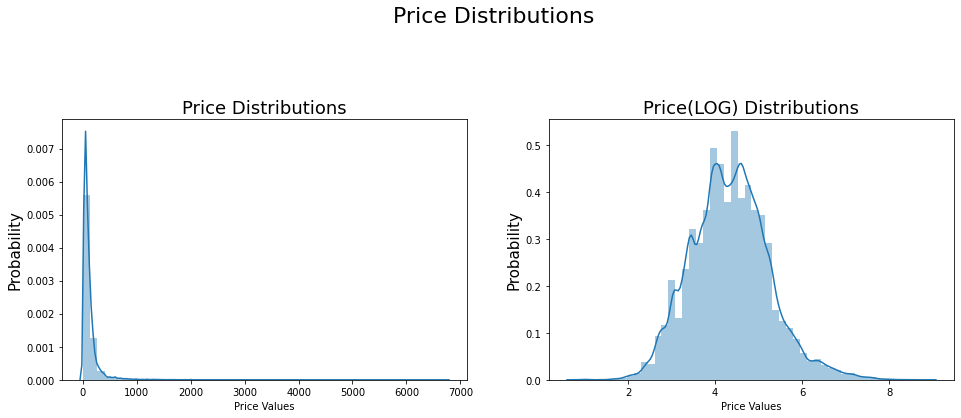

In [85]:
merge_df['price'].fillna(-1, inplace=True)

plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.distplot(merge_df['price'])
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(merge_df['price']+1.5))
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values")
g1.set_ylabel("Probability", fontsize=15)

plt.subplots_adjust(hspace = 0.4, top = 0.85)

plt.show()

# TIPOS DE PAGAMENTOS

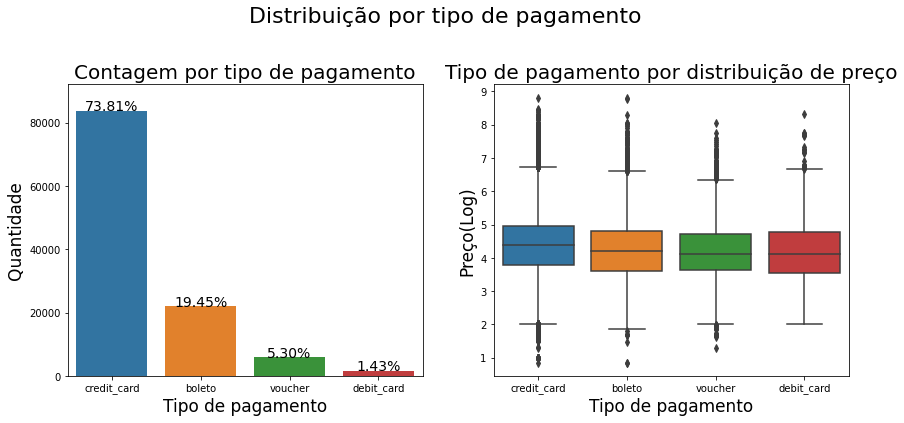

In [12]:
merge_df['price_log'] = np.log(merge_df['price'] + 1.5)

total = len(merge_df)

plt.figure(figsize=(14,6))

plt.suptitle('Distribuição por tipo de pagamento', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=merge_df[merge_df['payment_type'] != 'not_defined'])
g.set_title("Contagem por tipo de pagamento", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Quantidade", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type', y='price_log', data=merge_df[merge_df['payment_type'] != 'not_defined'])
g.set_title("Tipo de pagamento por distribuição de preço", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Preço(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

# DISTRIBUIÇÃO DE CLIENTES/VENDEDORES POR ESTADO

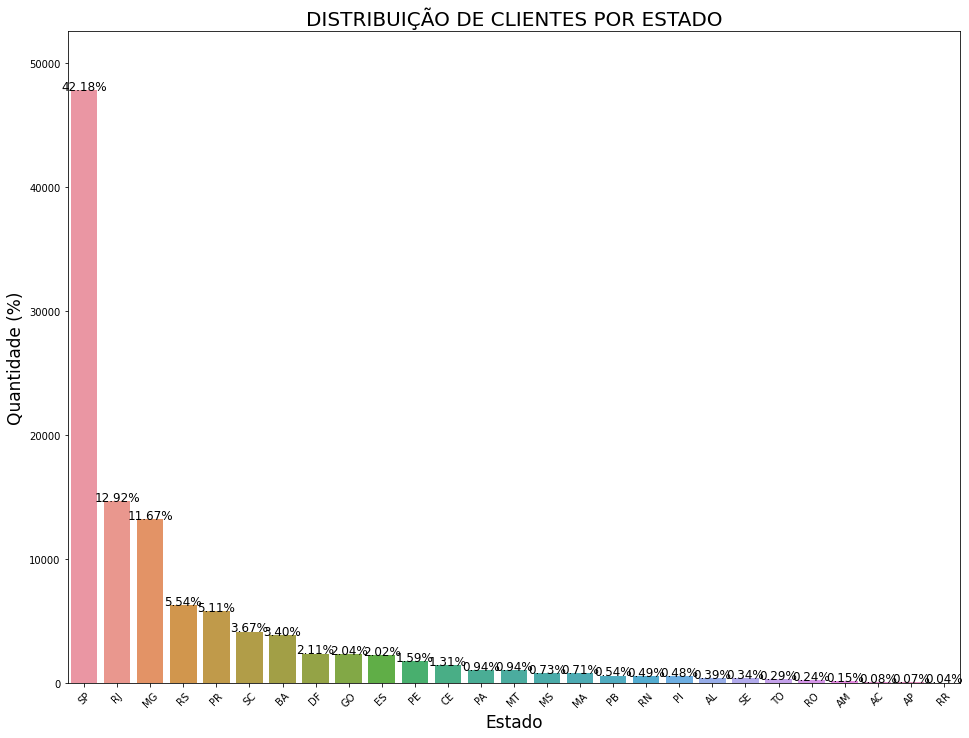

In [14]:
plt.figure(figsize=(16,12))

g = sns.countplot(x='customer_state', data=merge_df, orient='h', order = merge_df['customer_state'].value_counts().index)
g.set_title("DISTRIBUIÇÃO DE CLIENTES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.show()

(0.0, 88970.20000000001)

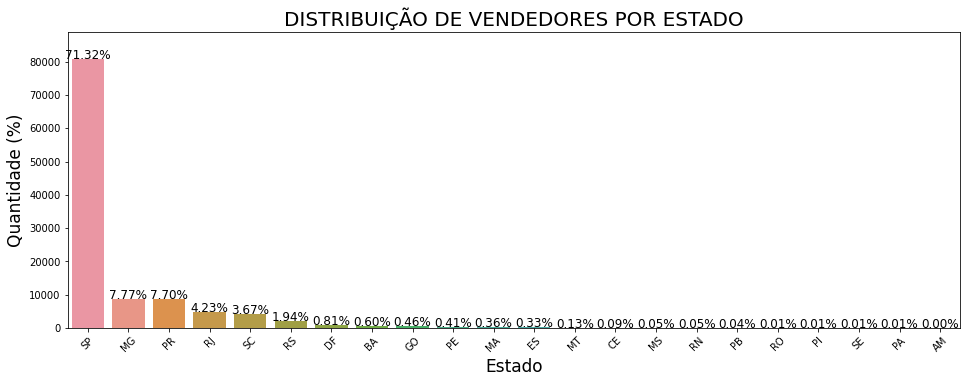

In [65]:
plt.figure(figsize=(16,12))

plt.subplot(212)
g = sns.countplot(x='seller_state', data=merge_df, orient='h', order = merge_df['seller_state'].value_counts().index)
g.set_title("DISTRIBUIÇÃO DE VENDEDORES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

# PRODUTOS MAIS VENDIDOS EM CADA MÊS DO ANO

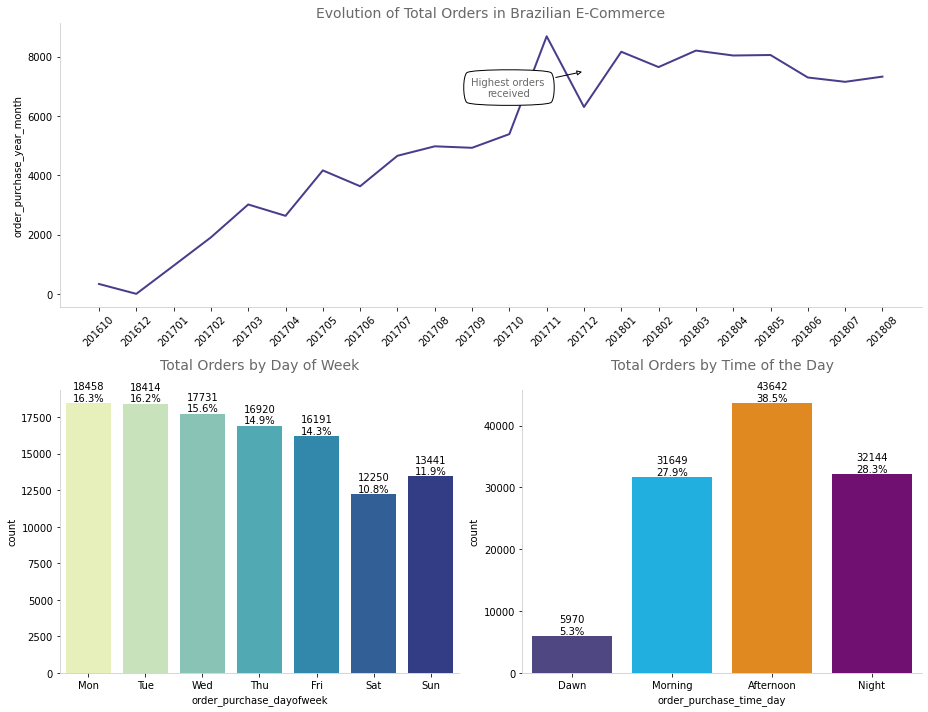

In [38]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=merge_df['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(merge_df, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(merge_df, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

CALCULO DO VALOR DO FRETE POR REGIAO E ESTADO.
CALCULA-SE A MEDIA DO VALOR DE QUAL REGIAO SERÁ ENVIADO O PRODUTO E QUAL O ESTADO DE DESTINO.

In [15]:
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

merge_df.loc[merge_df['customer_state'].isin(sudeste), 'Regiao do Comprador'] = 'Sudeste'
merge_df.loc[merge_df['customer_state'].isin(nordeste), 'Regiao do Comprador'] = 'Nordeste'
merge_df.loc[merge_df['customer_state'].isin(norte), 'Regiao do Comprador'] = 'Norte'
merge_df.loc[merge_df['customer_state'].isin(centro_oeste), 'Regiao do Comprador'] = 'Centro-Oeste'
merge_df.loc[merge_df['customer_state'].isin(sul), 'Regiao do Comprador'] = 'Sul'

In [16]:
def cross_heatmap(df, cols,normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]],  rownames=['Estado do Vendedor'],
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [17]:
cross_heatmap(merge_df[merge_df['price'] != -1], ['seller_state', 'Regiao do Comprador'], 
              values=merge_df[merge_df['price'] != -1]['freight_value'], aggfunc='mean')

Regiao do Comprador,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
Estado do Vendedor,,,,,
AM,nan,28.255000,nan,25.290000,nan
BA,30.273415,22.895625,47.342500,33.642448,40.299467
CE,65.456667,29.290278,85.614000,47.602273,53.125000
DF,12.927647,27.678491,58.371935,19.537642,26.395732
ES,36.895833,37.368039,60.022857,28.796813,40.336800
GO,14.562941,33.571290,26.595909,23.749076,30.641136
MA,27.150192,19.410886,28.859000,31.802922,42.660652
MG,27.095909,34.375710,42.508188,21.153917,29.005198
MS,26.228571,29.412308,21.410000,21.608750,25.600000
